# 序列模型
使用正弦函数和一些可加性噪声来生成序列数据，时间步为 1,2,…,1000

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

torch.Size([1000])

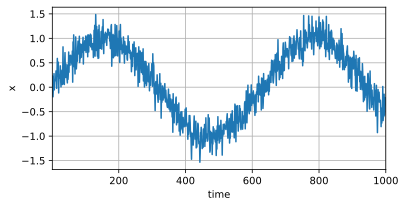

In [12]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# 加一点noise -- N(0,0.02)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

x.shape

将数据映射为数据对 yt=xt 和 xt=[xt−τ,…,xt−1]
- 预测 t时刻 == xt
- 需要前tau个时刻的x


In [11]:
tau = 4
#T= 1000
# x.shape  ---> torch.Size([1000])
# 996组训练样本 --->[[x1,..,x_tau],[x2,x3,x4,x_2*tau],.....,[x_T-tau,...,x_T]]
# --> label = [x_tau+1,x_tau+2,....,x_T]
features = torch.zeros((T-tau),tau)#torch.Size([996, 4])
for i in range(tau):
    features[:,i] = x[i:T-tau + i]
#预测的未来的x
labels = x[tau:].reshape((-1,1))


batch_size, n_train = 16, 600
#用前600个样本train
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

features.shape


torch.Size([996, 4])

使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(
                        nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1)
    )
    net.apply(init_weights)
    return net

loss = nn.MSELoss()



训练模型

In [16]:
def train(net,train_iter,loss,epochs,lr):
    optimizer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        print(f'epoch{epoch + 1}',
              f'loss:{d2l.evaluate_loss(net,train_iter,loss):f}'  )

net = get_net()
train(net,train_iter,loss,5,0.01)

epoch1 loss:0.060080
epoch2 loss:0.056233
epoch3 loss:0.054952
epoch4 loss:0.054500
epoch5 loss:0.054054


模型预测下一个时间步

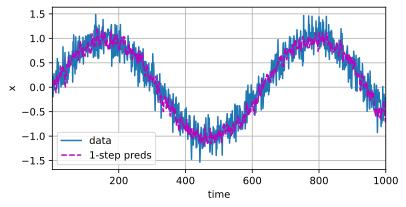

In [13]:
#把样本再放进训练好的model，看预测
#几乎没有拟合噪音
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

进行多步预测

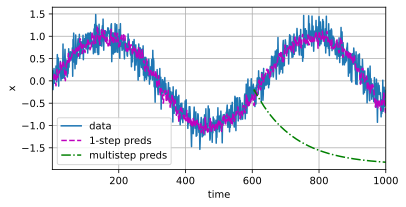

In [17]:
multistep_preds = torch.zeros(T)
## 用 前600个样本预测后面的400
# 看绿色的线
# 误差累积  --->  就坏掉了
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds','multistep preds'], xlim=[1, 1000], figsize=(6, 3))

更仔细地看一下k步预测

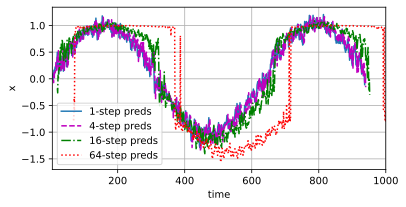

In [18]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
#给tau个数据，预测后step个数据
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
[features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time','x', legend=[f'{i}-step preds'for i in steps], xlim=[5, 1000], figsize=(6, 3))

观察可以发现，step稍微大一些，效果好一些，但是太大了效果就变差了